In [28]:
import numpy as np
import igl
import meshplot as mp

In [29]:
# Utility function to generate a tet grid
# n is a 3-tuple with the number of cell in every direction
# mmin/mmax are the grid bounding box corners

def tet_grid(n, mmin, mmax):
    nx = n[0]
    ny = n[1]
    nz = n[2]
    
    delta = mmax-mmin
    
    deltax = delta[0]/(nx-1)
    deltay = delta[1]/(ny-1)
    deltaz = delta[2]/(nz-1)
    
    T = np.zeros(((nx-1)*(ny-1)*(nz-1)*6, 4), dtype=np.int64)
    V = np.zeros((nx*ny*nz, 3))

    mapping = -np.ones((nx, ny, nz), dtype=np.int64)


    index = 0
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                mapping[i, j, k] = index
                V[index, :] = [i*deltax, j*deltay, k*deltaz]
                index += 1
    assert(index == V.shape[0])
    
    tets = np.array([
        [0,1,3,4],
        [5,2,6,7],
        [4,1,5,3],
        [4,3,7,5],
        [3,1,5,2],
        [2,3,7,5]
    ])
    
    index = 0
    for i in range(nx-1):
        for j in range(ny-1):
            for k in range(nz-1):
                indices = [
                    (i,   j,   k),
                    (i+1, j,   k),
                    (i+1, j+1, k),
                    (i,   j+1, k),

                    (i,   j,   k+1),
                    (i+1, j,   k+1),
                    (i+1, j+1, k+1),
                    (i,   j+1, k+1),
                ]
                
                for t in range(tets.shape[0]):
                    tmp = [mapping[indices[ii]] for ii in tets[t, :]]
                    T[index, :]=tmp
                    index += 1
                    
    assert(index == T.shape[0])
    
    V += mmin
    return V, T

In [30]:
# mp(V,T)

# Reading point cloud

In [31]:
# pi is point array, v is face array
pi, v = igl.read_triangle_mesh("data/cat.off")
pi /= 10
ni = igl.per_vertex_normals(pi, v)
mp.plot(pi, shading={"point_size": 8})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0, -23.…

# Setting up the Constraints

In [32]:
max_coordinate = np.max(pi, axis = 0)
min_coordinate = np.min(pi, axis = 0)
diagonal_len = igl.bounding_box_diagonal(pi)
print("max_coordinate: "+ str(max_coordinate))
print("min_coordinate: "+ str(min_coordinate))

v_num = pi.shape[0]
print("v_num", v_num)

max_coordinate: [32.7 16.7  5.8]
min_coordinate: [-22.7 -63.7 -99. ]
v_num 366


In [33]:
# return id of closed point
def find_closed_point(point, points):
    # distances of each point
    distances = np.linalg.norm(points - point, axis = 1)
    return np.argmin(distances)

In [34]:
# get appropriate eps for this point
def update_eps(_eps, _x_id, _x_coord, _norm):
    x_eps = _x_coord + _norm * _eps
    if(find_closed_point(x_eps, pi) == _x_id):
        return _eps
    else:
        return update_eps(_eps/2, _x_id, _x_coord, _norm)
    

In [35]:
# initial eps
eps = 0.01 * diagonal_len
# print(eps)

# get v+ and v- for each vertex v
constraint_v_coord_arr = np.zeros((3*v_num, 3), dtype = np.float64)
constraint_fval_arr = np.zeros(3*v_num, dtype = np.float64)
constraint_color_arr = np.zeros((3*v_num, 3), dtype = np.float64) #RGB
for v_id in range(v_num):
    coord = pi[v_id]
    norm = ni[v_id]
    constraint_v_coord_arr[3*v_id] = coord
    constraint_fval_arr[3*v_id] = 0.0
    constraint_color_arr[3*v_id] = [0.0, 0.0, 1.0]
    # for v+
    eps = update_eps(eps, v_id, coord, norm)
    constraint_v_coord_arr[3*v_id + 1] = coord + eps * norm
    constraint_fval_arr[3*v_id + 1] = eps
    constraint_color_arr[3*v_id + 1] = [1.0, 0.0, 0.0]
    # for v-
    eps = update_eps(eps, v_id, coord, -norm)
    constraint_v_coord_arr[3*v_id + 2] = coord - eps * norm
    constraint_fval_arr[3*v_id + 2] = -eps
    constraint_color_arr[3*v_id + 2] = [0.0, 1.0, 0.0]

# plot constraint points
mp.plot(constraint_v_coord_arr, c = constraint_color_arr, shading={"point_size": 8})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0120944…

# MLS Interpolation

In [36]:
# Generate grid n x n x n
n = 25
grid_vertices, T = tet_grid((n, n, n), min_coordinate - 0.05 * diagonal_len, max_coordinate + 0.05 * diagonal_len)

grid_v_num = grid_vertices.shape[0]
print("grid_v_num: ", grid_v_num)
wendland_h = 25 # wendlandRadius
poly_degree = 0
poly_coeff_num = 0
if(poly_degree == 0):
    poly_coeff_num = 1
elif(poly_degree == 1):
    poly_coeff_num = 4
elif(poly_degree == 2):
    poly_coeff_num = 10
print("poly_coeff_num: ", poly_coeff_num)

grid_v_num:  15625
poly_coeff_num:  1


In [37]:
# wendland weight function
def wendland(_r):
    return pow(1 - _r/wendland_h, 4)*(4*_r/wendland_h + 1)

# select constraint point ids for each grid vertex
def get_close_points_ids(_point, _points, _h):
    return np.argwhere(np.linalg.norm(_points - _point, axis = 1) < _h).ravel()

# get_close_points_ids([1,1,1], constraint_v_coord_arr, 10)

def get_poly_terms(_coord):
    x = _coord[0]
    y = _coord[1]
    z = _coord[2]
    if(poly_degree == 0):
        return np.array([1.0])
    elif(poly_degree == 1):
        return np.array([1.0, x, y, z])
    elif(poly_degree == 2):
        return np.array([1.0, x, y, z, x*x, y*y, z*z, x*y, y*z, z*x])
    print("error: incorrect poly_degree")
    return None
    

In [41]:
# MLS method 1, matrix operation
# solve DBX = b_arr for each grid vertex and then tell if BX>0 (outside)
# D is a diagonal matrix of weights
# DBX should be a projection of b_arr on plane DB
# X = (B_T B X)-1 B_T b_arr
def grid_MLS(grid_vertices, constraint_v_coord_arr, constraint_fval_arr):
    grid_v_num = grid_vertices.shape[0]
    grid_v_fval_arr = np.zeros(grid_v_num)   
    for i in range(grid_v_num):
        # each grid vertex
        close_points = get_close_points_ids(grid_vertices[i], constraint_v_coord_arr, wendland_h)
        if (len(close_points) < poly_coeff_num*2):
            grid_v_fval_arr[i] = 50 # any positive value, means outside
        else:
            B = np.zeros((len(close_points), poly_coeff_num))
            DIAG = np.zeros((len(close_points), len(close_points)))
            b_arr = np.zeros((len(close_points), 1))    
            for j in range(len(close_points)):
                r = np.linalg.norm(grid_vertices[i] - constraint_v_coord_arr[close_points[j]])
                DIAG[j][j] = wendland(r)
                B[j] = get_poly_terms(constraint_v_coord_arr[close_points[j]])
                b_arr[j] = constraint_fval_arr[close_points[j]]
            A = np.dot(np.dot(np.transpose(B), DIAG), B)
            C = np.dot(np.dot(np.transpose(B), DIAG), b_arr)
            X = np.linalg.solve(A, C)
            for j in range(len(close_points)):
                grid_v_fval_arr[i] += np.dot(B[j], X)

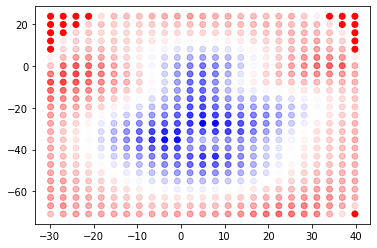

In [63]:
ind = np.zeros_like(grid_v_fval_arr)
ind[grid_v_fval_arr >= 0] = 1
ind[grid_v_fval_arr < 0] = -1
# mp.plot(grid_vertices, c=ind, shading={"point_size": 8,"width": 800, "height": 800})
plane = grid_vertices.reshape((n,n,n,3))[:,:,0,:].reshape([n*n,3])
val_plane = grid_v_fval_arr.reshape((n,n,n))[:,:,0].ravel()
val_plane = val_plane/np.max(val_plane)
ind_plane = ind.reshape((n,n,n))[:,:,0].ravel()
colors_plane = np.zeros((n*n,3))
for i in range(n*n):
    if(val_plane[i]>0):
        colors_plane[i][0] = 1
    else:
        colors_plane[i][2] = 1
alphas_plane = np.absolute(val_plane)
alphas_plane = alphas_plane/np.max(alphas_plane)
# print(colors_plane)
# mp.plot(plane, c=colors_plane, shading={"point_size": 8,"width": 800, "height": 800})
plt.scatter(plane[:,0], plane[:,1],c=colors_plane, alpha = alphas_plane)

In [39]:
# MLS method 2, DEPRECATED
# try to build MLS equations by elements instead of too many matrix operations

# # get f val for each grid vertex (different f)
# grid_v_fval_arr = np.zeros(grid_v_num, dtype = np.float64)
# for grid_v_i in range(grid_v_num):
#     grid_v_coord = grid_vertices[grid_v_i]
#     close_points_ids = get_close_points_ids(grid_v_coord, constraint_v_coord_arr, wendland_h)
#     close_point_num = close_points_ids.shape[0]
#     if(close_point_num < 2 * poly_coeff_num):
#         grid_v_fval_arr[grid_v_i] = 1.0 # any positive value (means outside)
#         continue
#     # solve the MLS derivative equations of matrix
# #     print("close_points_ids: ", close_points_ids)
#     weight_arr = np.zeros(close_point_num, dtype = np.float64)
#     close_v_terms = np.zeros((close_point_num, poly_coeff_num), dtype = np.float64)
#     close_v_constraint_vals = np.zeros(close_point_num, dtype = np.float64)
#     for i in range(close_point_num):
#         close_v_id = close_points_ids[i]
#         close_v_coord = constraint_v_coord_arr[close_v_id]
# #         print("shape of constraint_v_coord_arr: ", constraint_v_coord_arr.shape)
# #         print("close_v_coord: ", close_v_coord)
#         close_v_terms[i] = get_poly_terms(close_v_coord)
#         close_v_constraint_vals[i] = constraint_fval_arr[close_v_id]
#         weight_arr[i] = wendland(np.linalg.norm(grid_v_coord - close_v_coord))
# #     print("weight_arr: ", weight_arr)
#     # solve AX = B
#     mat_a = np.zeros((poly_coeff_num, poly_coeff_num), dtype = np.float64)
#     arr_b = np.zeros(poly_coeff_num, dtype = np.float64)
#     for i in range(poly_coeff_num):
#        a_line = np.zeros((poly_coeff_num), dtype = np.float64)
#        b_element = 0.0
#        for j in range(close_point_num):
#            a_line += weight_arr[j] * close_v_terms[j][i] *close_v_terms[j]
#            b_element += weight_arr[j] * close_v_constraint_vals[j] * close_v_terms[j][i]
#        mat_a[i] = a_line
#        arr_b[i] = b_element
#     count += 1
# #     print("mat_a", mat_a)
# #     print("arr_b", arr_b)
# coefficients = np.linalg.solve(mat_a, arr_b)
# grid_v_terms = get_poly_terms(grid_v_coord)
# grid_v_fval_arr[grid_v_i] = np.multiply(coefficients, grid_v_terms)
    

# # Treshold fx to visualize inside outside
# print(count)
# ind = np.zeros_like(grid_v_fval_arr)
# ind[grid_v_fval_arr >= 0] = 1
# ind[grid_v_fval_arr < 0] = -1
# print(np.argwhere(grid_v_fval_arr >= 0).shape)
# print(np.argwhere(grid_v_fval_arr < 0).shape)
# # mp.plot(grid_vertices, c = ind, shading={"point_size": 8,"width": 800, "height": 800})

# Implementing a spatial index to accelerate neighbor calculations

In [12]:
# reference to the cube mapping of tet_grid function
# cube (i,j,k) to cube id, cube id to the vertices in it

mmin =  min_coordinate - 0.05 * diagonal_len
mmax =  max_coordinate + 0.05 * diagonal_len
delta = mmax-mmin

nx = n
ny = n
nz = n

deltax = delta[0]/(nx-1)
deltay = delta[1]/(ny-1)
deltaz = delta[2]/(nz-1)

# cube triple to cube id
cube_mapping = -np.ones((nx-1, ny-1, nz-1), dtype=np.int64)

index = 0
for i in range(nx-1):
    for j in range(ny-1):
        for k in range(nz-1):
            cube_mapping[i, j, k] = index
            index += 1

cube_to_vertice_ids = []
for i in range((nx-1)*(ny-1)*(nz-1)):
    cube_to_vertice_ids.append([])

vertices = pi
for v_id in range(v_num):
    v_coord = vertices[v_id]
    cube_x = int((v_coord[0] - mmin[0])/deltax)
    cube_y = int((v_coord[1] - mmin[1])/deltay)
    cube_z = int((v_coord[2] - mmin[2])/deltaz)
    cube_id = cube_mapping[cube_x, cube_y, cube_z]
    cube_to_vertice_ids[cube_id].append(v_id)
    
d_triples = []
a = [-1, 0, 1]
for i in range(3):
    for j in range(3):
        for k in range(3):
            d_triples.append([a[i], a[j], a[k]])
              
# new find_closed_point of constraints
def find_closed_point(_point, points = None):
    v_ids_probe = []
    cube_x = int((_point[0] - mmin[0])/deltax)
    cube_y = int((_point[1] - mmin[1])/deltay)
    cube_z = int((_point[2] - mmin[2])/deltaz)
    cube_triple = [cube_x, cube_y, cube_z]

    weight = 0
    while(len(v_ids_probe) == 0):
        weight += 1
        for i in range(27):
            tmp_cube_triple = np.array(cube_triple) + np.array(d_triples[i]) * weight
            # boundary 
            if(np.min(tmp_cube_triple) >= 0 and np.min(np.array([nx-1, ny-1, nz-1])-np.array(tmp_cube_triple)) >=0):
                tmp_cube_id = cube_mapping[tmp_cube_triple[0]][tmp_cube_triple[1]][tmp_cube_triple[2]]
                for v_id in cube_to_vertice_ids[tmp_cube_id]:
                    v_ids_probe.append(v_id)
    points = vertices[v_ids_probe]
    distances = np.linalg.norm(points - _point, axis = 1)
    i = np.argmin(distances)
    return v_ids_probe[i]

# new get_close_points_ids for MLS
def get_close_points_ids(_point, _points, _h):
    v_ids_probe = []
    cube_x = int((_point[0] - mmin[0])/deltax)
    cube_y = int((_point[1] - mmin[1])/deltay)
    cube_z = int((_point[2] - mmin[2])/deltaz)
    cube_triple = [cube_x, cube_y, cube_z]
    dx = int(_h/deltax)
    dy = int(_h/deltay)
    dz = int(_h/deltaz)
    for i in range(max(cube_x - dx, 0), min(cube_x + dx, nx -1)):
        for j in range(max(cube_y - dy, 0), min(cube_y + dy, ny -1)):
            for k in range(max(cube_z - dz, 0), min(cube_z + dz, nz -1)):
                tmp_cube_id = cube_mapping[i,j,k]
                for v_id in cube_to_vertice_ids[tmp_cube_id]:
                    v_ids_probe.append(v_id)
    return np.argwhere(np.linalg.norm(_points - _point, axis = 1) < _h).ravel()

## then re-run the last cell of "Setting up Constraints" and "MLS Interpolation"

# Marching to extract surface

In [15]:
# Marcing tet to extract surface

surface_v, surface_f, _, _ = igl.marching_tets(grid_vertices, T, grid_v_fval_arr, 0)
mp.plot(surface_v, surface_f, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.2994623…

# Using a non-axis-aligned grid

In [27]:
vertices1, faces1 = igl.read_triangle_mesh("data/luigi.off")
mp.plot(vertices1, shading={"point_size": 8})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(11.288000…

In [ ]:
v1_num = len(vertices1)
# initial eps
eps = 0.01 * diagonal_len
# print(eps)

# get v+ and v- for each vertex v
constraint_v_coord_arr = np.zeros((3*v1_num, 3), dtype = np.float64)
constraint_fval_arr = np.zeros(3*v_num, dtype = np.float64)
constraint_color_arr = np.zeros((3*v_num, 3), dtype = np.float64) #RGB
for v_id in range(v_num):
    coord = pi[v_id]
    norm = ni[v_id]
    constraint_v_coord_arr[3*v_id] = coord
    constraint_fval_arr[3*v_id] = 0.0
    constraint_color_arr[3*v_id] = [0.0, 0.0, 1.0]
    # for v+
    eps = update_eps(eps, v_id, coord, norm)
    constraint_v_coord_arr[3*v_id + 1] = coord + eps * norm
    constraint_fval_arr[3*v_id + 1] = eps
    constraint_color_arr[3*v_id + 1] = [1.0, 0.0, 0.0]
    # for v-
    eps = update_eps(eps, v_id, coord, -norm)
    constraint_v_coord_arr[3*v_id + 2] = coord - eps * norm
    constraint_fval_arr[3*v_id + 2] = -eps
    constraint_color_arr[3*v_id + 2] = [0.0, 1.0, 0.0]

# Optional 1

In [1]:
import numpy as np
import igl
import meshplot as mp
import math
import random
import matplotlib.pyplot as plt

## Create 2-D Dataset

In [2]:
def create_2d_boundary():
    vnum = 100
    radius = 1.0
    dtheta = 2*math.pi/vnum
    rx = [0.5 + random.uniform(0,1)/2 for i in range(vnum)]
    vertices_a = np.zeros((vnum, 2))
    for vi in range(vnum):
        vertices_a[vi][0] = rx[vi]*math.cos(dtheta*vi)
        vertices_a[vi][1] = rx[vi]*math.sin(dtheta*vi)
    window_len = 3
    for vi in range(vnum):
        x = 0
        y = 0
        for j in range(window_len):
            x += vertices_a[(vi+j)%vnum][0]
            y += vertices_a[(vi+j)%vnum][1]
        vertices[vi][0] = x/window_len
        vertices[vi][1] = y/window_len
    plt.plot(vertices[:,0], vertices[:, 1])
    np.savetxt('data/2dboundary.txt', vertices, delimiter=' ')

create_2d_boundary()

NameError: name 'vertices' is not defined

## Normal Constraints

# Assign 2 Optional 1

## Create 2-D Dataset

In [3]:
import numpy as np
import igl
import meshplot as mp
import math
import random
import matplotlib.pyplot as plt

In [10]:
def create_2d_boundary():
    vnum = 200
    radius = 1.0
    dtheta = 2*math.pi/vnum
    rx = [0.5 + random.uniform(0,1)/2 for i in range(vnum)]
    vertices_a = np.zeros((vnum, 2))
    vertices = np.zeros((vnum, 2))
    for vi in range(vnum):
        vertices_a[vi][0] = rx[vi]*math.cos(dtheta*vi)
        vertices_a[vi][1] = rx[vi]*math.sin(dtheta*vi)
    window_len = 5
    for vi in range(vnum):
        x = 0
        y = 0
        for j in range(window_len):
            x += vertices_a[(vi+j)%vnum][0]
            y += vertices_a[(vi+j)%vnum][1]
        vertices[vi][0] = x/window_len
        vertices[vi][1] = y/window_len
    plt.plot(vertices[:,0], vertices[:, 1])
    np.savetxt('data/2dboundary.txt', vertices, delimiter=' ')
    np.savetxt('data/2dnorm.txt', vertices_a, delimiter=' ')

# create_2d_boundary()

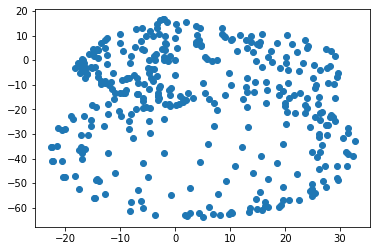

In [23]:
# vertices = np.loadtxt("data/2dboundary.txt")
# norms = np.loadtxt("data/2dnorm.txt")
vertices, faces = igl.read_triangle_mesh("data/cat.off")
vertices = vertices/10
normals = igl.per_vertex_normals(vertices, faces)
vertices = vertices[:, :2]
normals = normals[:, :2]
vnum = vertices.shape[0]
# print(vnum)
# print(normals.shape)
plt.plot(vertices[:,0], vertices[:, 1], marker = 'o' ,linestyle="")
max_coordinate = np.max(vertices, axis = 0)
min_coordinate = np.min(vertices, axis = 0)
diagonal_len = np.linalg.norm(max_coordinate - min_coordinate)
# print(diagonal_len)

## Previous Constraints

In [27]:
# return id of closed point
def find_closed_point(point, points):
    # distances of each point
    distances = np.linalg.norm(points - point, axis = 1)
    return np.argmin(distances)

# get appropriate eps for this point
def update_eps(_eps, _x_id, _x_coord, _norm):
    x_eps = _x_coord + _norm * _eps
    if(find_closed_point(x_eps, vertices) == _x_id):
        return _eps
    else:
        return update_eps(_eps/2, _x_id, _x_coord, _norm)

# initial eps
eps = 0.01 * diagonal_len
# print(eps)

# get v+ and v- for each vertex v
constraint_v_coord_arr = np.zeros((3*vnum, 2), dtype = np.float64)
constraint_fval_arr = np.zeros(3*vnum, dtype = np.float64)
constraint_color_arr = np.zeros((3*vnum, 3), dtype = np.float64) #RGB
for v_id in range(vnum):
    coord = vertices[v_id]
    normal = normals[v_id]
    constraint_v_coord_arr[3*v_id] = coord
    constraint_fval_arr[3*v_id] = 0.0
    constraint_color_arr[3*v_id] = [0.0, 0.0, 1.0]
    # for v+
    eps = update_eps(eps, v_id, coord, normal)
    constraint_v_coord_arr[3*v_id + 1] = coord + eps * normal
    constraint_fval_arr[3*v_id + 1] = eps
    constraint_color_arr[3*v_id + 1] = [1.0, 0.0, 0.0]
    # for v-
    eps = update_eps(eps, v_id, coord, -normal)
    constraint_v_coord_arr[3*v_id + 2] = coord - eps * normal
    constraint_fval_arr[3*v_id + 2] = -eps
    constraint_color_arr[3*v_id + 2] = [0.0, 1.0, 0.0]

# plot constraint points
constrs_3d = np.hstack([constraint_v_coord_arr, np.zeros((3*vnum,1))])
mp.plot(constrs_3d, c = constraint_color_arr, shading={"point_size":8})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0005149…

## Normal Constraints

## MLS

In [14]:
def build_grids(n, mmin, mmax):
    nx = n[0]
    ny = n[1]
    delta = mmax-mmin
    deltax = delta[0]/(nx-1)
    deltay = delta[1]/(ny-1)
    grids = np.zeros((nx*ny, 2))
    index = 0
    for i in range(nx):
        for j in range(ny):
            grids[index, :] = [i*deltax, j*deltay]
            index += 1
    return grids

poly_degree = 2
def get_poly_terms(_coord):
    x = _coord[0]
    y = _coord[1]
    if(poly_degree == 0):
        return np.array([1.0])
    elif(poly_degree == 1):
        return np.array([1.0, x, y])
    elif(poly_degree == 2):
        return np.array([1.0, x, y, x*x, y*y, x*y])
    print("error: incorrect poly_degree")
    return None

poly_coeff_num = 0
if(poly_degree == 0):
    poly_coeff_num = 1
elif(poly_degree == 1):
    poly_coeff_num = 3
elif(poly_degree == 2):
    poly_coeff_num = 6

# wendland weight function
wendland_h = 0.08
def wendland(_r):
    return pow(1 - _r/wendland_h, 4)*(4*_r/wendland_h + 1)


mmin =  min_coordinate - 0.05 * diagonal_len
mmax =  max_coordinate + 0.05 * diagonal_len
delta = mmax-mmin
n=[100, 100]
nx = n[0]
ny = n[1]

deltax = delta[0]/(nx-1)
deltay = delta[1]/(ny-1)

# cube triple to cube id
cube_mapping = -np.ones((nx-1, ny-1), dtype=np.int64)

index = 0
for i in range(nx-1):
    for j in range(ny-1):
        cube_mapping[i, j] = index
        index += 1

cube_to_vertice_ids = []
for i in range((nx-1)*(ny-1)):
    cube_to_vertice_ids.append([])

for v_id in range(vnum):
    v_coord = vertices[v_id]
    cube_x = int((v_coord[0] - mmin[0])/deltax)
    cube_y = int((v_coord[1] - mmin[1])/deltay)
    cube_id = cube_mapping[cube_x, cube_y]
    cube_to_vertice_ids[cube_id].append(v_id)
    
d_triples = []
a = [-1, 0, 1]
for i in range(3):
    for j in range(3):
            d_triples.append([a[i], a[j]])
              
# new find_closed_point of constraints
def find_closed_point(_point, points = None):
    v_ids_probe = []
    cube_x = int((_point[0] - mmin[0])/deltax)
    cube_y = int((_point[1] - mmin[1])/deltay)
    cube_triple = [cube_x, cube_y]

    weight = 0
    while(len(v_ids_probe) == 0):
        weight += 1
        for i in range(9):
            tmp_cube_triple = np.array(cube_triple) + np.array(d_triples[i]) * weight
            # boundary 
            if(np.min(tmp_cube_triple) >= 0 and np.min(np.array([nx-1, ny-1])-np.array(tmp_cube_triple)) >=0):
                tmp_cube_id = cube_mapping[tmp_cube_triple[0]][tmp_cube_triple[1]]
                for v_id in cube_to_vertice_ids[tmp_cube_id]:
                    v_ids_probe.append(v_id)
    points = vertices[v_ids_probe]
    distances = np.linalg.norm(points - _point, axis = 1)
    i = np.argmin(distances)
    return v_ids_probe[i]

# new get_close_points_ids for MLS
def get_close_points_ids(_point, _points, _h):
    v_ids_probe = []
    cube_x = int((_point[0] - mmin[0])/deltax)
    cube_y = int((_point[1] - mmin[1])/deltay)
    cube_triple = [cube_x, cube_y]
    dx = int(_h/deltax)
    dy = int(_h/deltay)
    for i in range(max(cube_x - dx, 0), min(cube_x + dx, nx -1)):
        for j in range(max(cube_y - dy, 0), min(cube_y + dy, ny -1)):
            tmp_cube_id = cube_mapping[i,j]
            for v_id in cube_to_vertice_ids[tmp_cube_id]:
                v_ids_probe.append(v_id)
    return np.argwhere(np.linalg.norm(_points - _point, axis = 1) < _h).ravel()


def calc_grid(grid_vertices, constraint_v_coord_arr, constraint_fval_arr):
    grid_v_num = grid_vertices.shape[0]
    grid_v_fval_arr = np.zeros(grid_v_num)   
    for i in range(grid_v_num):
        # each grid vertex
        close_points = get_close_points_ids(grid_vertices[i], constraint_v_coord_arr, wendland_h)
        if (len(close_points) < poly_coeff_num*2):
            grid_v_fval_arr[i] = 50 # any positive value, means outside
        else:
            B = np.zeros((len(close_points), poly_coeff_num))
            DIAG = np.zeros((len(close_points), len(close_points)))
            b_arr = np.zeros((len(close_points), 1))    
            for j in range(len(close_points)):
                r = np.linalg.norm(grid_vertices[i] - constraint_v_coord_arr[close_points[j]])
                DIAG[j][j] = wendland(r)
                B[j] = get_poly_terms(constraint_v_coord_arr[close_points[j]])
                b_arr[j] = constraint_fval_arr[close_points[j]]
            A = np.dot(np.dot(np.transpose(B), DIAG), B)
            C = np.dot(np.dot(np.transpose(B), DIAG), b_arr)
            X = np.linalg.solve(A, C)
            for j in range(len(close_points)):
                grid_v_fval_arr[i] += np.dot(B[j], X)
    ind = np.zeros_like(grid_v_fval_arr)
    ind[grid_v_fval_arr >= 0] = 1
    ind[grid_v_fval_arr < 0] = -1
    mp.plot(grid_vertices, c=ind, shading={"point_size": 0.05,"width": 800, "height": 800})

grid_vertices = build_grids(n, min_coordinate, max_coordinate)
calc_grid(grid_vertices, constraint_v_coord_arr, constraint_fval_arr)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.8213719…